# **Predict news category**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from google.colab import files
uploaded = files.upload()

Saving newsCorpora.csv to newsCorpora.csv


In [8]:
news_data = pd.read_csv('newsCorpora.csv', sep='\t')
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


# **Understanding Data**

In [9]:
news_data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


<BarContainer object of 10985 artists>

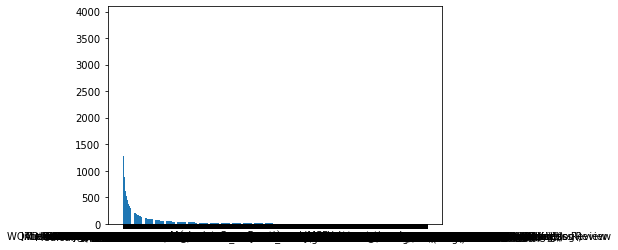

In [25]:
plt.bar(news_data.PUBLISHER.value_counts().index , news_data.PUBLISHER.value_counts().values)

In [0]:
news_data.drop(columns=['ID','URL','STORY','HOSTNAME','TIMESTAMP'],inplace=True)


In [11]:
news_data.head()

,TITLE,PUBLISHER,CATEGORY
0,"Fed official says weak data caused by weather,...",Los Angeles Times,b
1,Fed's Charles Plosser sees high bar for change...,Livemint,b
2,US open: Stocks fall after Fed official hints ...,IFA Magazine,b
3,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,b


# **Nltk on the titel column**

In [0]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

In [0]:
def f(t):
    return t.replace(',','').replace('?','').replace('.','').replace(':','').replace(';','').replace('!','')
news_data['new_title'] =news_data.TITLE.map(f)

In [13]:
news_data.new_title.head()

0    Fed official says weak data caused by weather ...
1    Fed's Charles Plosser sees high bar for change...
2    US open Stocks fall after Fed official hints a...
3    Fed risks falling 'behind the curve' Charles P...
4    Fed's Plosser Nasty Weather Has Curbed Job Growth
Name: new_title, dtype: object

In [0]:
ps = PorterStemmer()

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def stem_func(r):
    words = word_tokenize(r)
    sent = []
    for word in words:
        sent.append(ps.stem(word))
    return ' '.join(sent)

news_data['stem_title'] = news_data.new_title.map(stem_func)

In [19]:
news_data.head()

,TITLE,PUBLISHER,CATEGORY,new_title,stem_title
0,"Fed official says weak data caused by weather,...",Los Angeles Times,b,Fed official says weak data caused by weather ...,fed offici say weak data caus by weather shoul...
1,Fed's Charles Plosser sees high bar for change...,Livemint,b,Fed's Charles Plosser sees high bar for change...,fed 's charl plosser see high bar for chang in...
2,US open: Stocks fall after Fed official hints ...,IFA Magazine,b,US open Stocks fall after Fed official hints a...,US open stock fall after fed offici hint at ac...
3,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,b,Fed risks falling 'behind the curve' Charles P...,fed risk fall 'behind the curv ' charl plosser...
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,b,Fed's Plosser Nasty Weather Has Curbed Job Growth,fed 's plosser nasti weather ha curb job growth


In [0]:
cv = CountVectorizer(stop_words='english')

In [21]:
cv.fit(news_data.stem_title)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
out = cv.transform(news_data.stem_title)

In [23]:
len(cv.vocabulary_)

43093

In [25]:
out.shape

(422419, 43093)

<hr>

**Giving a try to generate clusters of titles and then use both title and Publisher.**

In [0]:
from sklearn.cluster import DBSCAN

In [0]:
dbscan = DBSCAN(eps=.5, min_samples=10)

In [38]:
dbscan.fit(out)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [0]:
news_data['title_cat_dbscan'] = dbscan.labels_

In [40]:
news_data.title_cat_dbscan.value_counts()

-1      419724
 81        145
 4          60
 3          59
 79         53
         ...  
 38         10
 132        10
 36         10
 134        10
 49         10
Name: title_cat_dbscan, Length: 165, dtype: int64

**Not sucessfull inclustering the titels**

<hr>

## **Data Preprocessing**

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()

In [0]:
target_data = le.fit_transform(news_data.CATEGORY)

In [43]:
target_data.shape

(422419,)

In [0]:
feature_data = out

In [45]:
feature_data.shape

(422419, 43093)

In [0]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(feature_data, target_data)

# **RandomForest Classifier**

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc = RandomForestClassifier()

In [49]:
rfc.fit(trainX , trainY)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
rfc.score(testX , testY)

0.9394725628521376

In [0]:
y_pred = rfc.predict(testX)

In [0]:
from sklearn.metrics import confusion_matrix

In [56]:
confusion_matrix(testY , y_pred)

array([[27050,   708,   242,  1173],
       [  566, 37104,   154,   330],
       [  485,   420, 10451,   158],
       [ 1360,   635,   161, 24608]])

In [78]:
pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=testY), columns=['Predicted b', 'Predicted e','Predicted m', 'Predicted t'], index=['Actual b', 'Actual e','Actual m', 'Actual t'])

,Predicted b,Predicted e,Predicted m,Predicted t
Actual b,27050,708,242,1173
Actual e,566,37104,154,330
Actual m,485,420,10451,158
Actual t,1360,635,161,24608


**Validating**

In [77]:
print(len(trainY[trainY ==0]) + len(testY[testY ==0]))  ## 0 encoding for b
print(len(testY[testY ==0]))  # true 0

115967
29173


In [76]:
print(len(trainY[trainY ==1]) + len(testY[testY ==1])) ## 1 encoding for e
print( len(testY[testY ==1])) # true 1

152469
38154


In [74]:
print(len(trainY[trainY ==2]) + len(testY[testY ==2])) ## 2 encoding for m

45639


In [75]:
print(len(trainY[trainY ==3]) + len(testY[testY ==3])) ## 3 encoding for t

108344


<hr>

# **Logistic Regression**

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9439515174470906

In [0]:
y_pred = lr.predict(testX)

In [80]:
pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=testY), columns=['Predicted b', 'Predicted e','Predicted m', 'Predicted t'], index=['Actual b', 'Actual e','Actual m', 'Actual t'])

,Predicted b,Predicted e,Predicted m,Predicted t
Actual b,26986,460,273,1454
Actual e,419,37270,142,323
Actual m,393,256,10692,173
Actual t,1456,449,121,24738


* Not much improvement

# **Conclusion :**
* Batter model can be built but it take lots of time because of its large data size of (422419, 43093)